## Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import re
from time import time
from pathlib import Path
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torch import nn, optim
import optuna

c:\Users\adaml\miniforge3\envs\cs467proj\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\adaml\miniforge3\envs\cs467proj\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = Path('./data')
preprocesssed_dir = data_dir / 'preprocessed'
datasets = ['en_handwritten', 'hhd', 'mashtots', 'emnist']
splits = ['train', 'dev', 'test']

## DF Creation

Create a `/data` dir with subdirs `/data/preprocessed`, `/data/emnist`, `/data/en_handwritten`, `/data/hhd`, `/data/en_handwritten` and populate it with data from the corresponding sources.
 - [emnist](https://www.nist.gov/itl/products-and-services/emnist-dataset)
 - [en_handwritten](https://www.kaggle.com/datasets/dhruvildave/english-handwritten-characters-dataset)
 - [mashtots](https://www.kaggle.com/competitions/mashtots-dataset-v2)
 - [hhd](https://tc11.cvc.uab.es/datasets/HHD_v0_1)

### Emnist --> DF

In [ ]:
data_type_choice = 'byclass'
train_data = pd.read_csv(data_dir / f'emnist/emnist-{data_type_choice}-train.csv', header=None)
test_data = pd.read_csv(data_dir / f'emnist/emnist-{data_type_choice}-test.csv', header=None)

def row_to_label_and_image(row):
    # Get the label (assumed to be in the first column)
    label = row.iloc[0]
    # Convert the rest of the row into a grayscale image
    img_array = np.array(row.iloc[1:], dtype=np.uint8).reshape((28, 28))
    img = Image.fromarray(img_array, mode='L')
    return pd.Series({'y': label, 'X': img})

# Apply the function to each row to create dfs
train_df = train_data.apply(row_to_label_and_image, axis=1)
test_df = test_data.apply(row_to_label_and_image, axis=1)

# Train-dev split
train_df, dev_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['y'])

In [ ]:
# Save all
emnist_preprocessed_dir = preprocesssed_dir / "emnist"
torch.save(train_df, emnist_preprocessed_dir / "train_df.pt")
torch.save(dev_df, emnist_preprocessed_dir / "dev_df.pt")
torch.save(test_df, emnist_preprocessed_dir / "test_df.pt")

In [ ]:
# Load the DataFrames back from .pt files
train_df = torch.load(emnist_preprocessed_dir / "train_df.pt")
dev_df = torch.load(emnist_preprocessed_dir / "dev_df.pt")
test_df = torch.load(emnist_preprocessed_dir / "test_df.pt")

C:\Users\adaml\AppData\Local\Temp\ipykernel_16392\727998152.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_df = torch.load(emnist_preprocessed_dir / "train_df.pt"

### HHD --> DF

In [ ]:
def load_data_from_directory(directory: Path):
    data = []
    # Traverse through each class folder
    for label_folder in directory.iterdir():
        if label_folder.is_dir():
            label = int(label_folder.name)  # Convert folder name to integer for label
            # Load each image in the subfolder
            for img_file in label_folder.iterdir():
                img = Image.open(img_file).convert('L')  # Convert to grayscale if needed
                data.append((label, img))
    # Create DataFrame
    return pd.DataFrame(data, columns=['y', 'X'])

# Load train and test
train_df = load_data_from_directory(data_dir / 'hhd/TRAIN')
test_df = load_data_from_directory(data_dir / 'hhd/TEST')

# Train-dev split
train_df, dev_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['y'])

In [ ]:
# Save all
hhd_preprocessed_dir = preprocesssed_dir / "hhd"
torch.save(train_df, hhd_preprocessed_dir / "train_df.pt")
torch.save(dev_df, hhd_preprocessed_dir / "dev_df.pt")
torch.save(test_df, hhd_preprocessed_dir / "test_df.pt")

In [ ]:
# Load the DataFrames back from .pt files
train_df = torch.load(hhd_preprocessed_dir / "train_df.pt")
dev_df = torch.load(hhd_preprocessed_dir / "dev_df.pt")
test_df = torch.load(hhd_preprocessed_dir / "test_df.pt")

C:\Users\adaml\AppData\Local\Temp\ipykernel_16392\393591457.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_df = torch.load(hhd_preprocessed_dir / "train_df.pt")
C

### English Handwritten --> DF

In [ ]:
def load_en_handwritten_data(directory: Path):
    data = []
    # Pattern to extract the class label from the filename
    pattern = re.compile(r'img(\d+)-\d+\.png')
    
    # Iterate over each image file in the directory
    for img_file in directory.iterdir():
        if img_file.is_file() and img_file.suffix == '.png':
            match = pattern.match(img_file.name)
            if match:
                label = int(match.group(1))  # Extract class label from filename
                img = Image.open(img_file).convert('L')  # Convert to grayscale if needed
                data.append((label, img))
    
    # Create DataFrame
    return pd.DataFrame(data, columns=['y', 'X'])

# Define the directory as a Path object
en_handwritten_df = load_en_handwritten_data(data_dir / "en_handwritten/Img")

# Train-test-dev split
train_df, test_df = train_test_split(en_handwritten_df, test_size=0.2, random_state=42, stratify=en_handwritten_df['y'])
train_df, dev_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['y'])

In [ ]:
# Save all
en_handwritten_preprocessed_dir = preprocesssed_dir / "en_handwritten"
torch.save(train_df, en_handwritten_preprocessed_dir / "train_df.pt")
torch.save(dev_df, en_handwritten_preprocessed_dir / "dev_df.pt")
torch.save(test_df, en_handwritten_preprocessed_dir / "test_df.pt")

In [ ]:
# Load the DataFrames back from .pt files
train_df = torch.load(en_handwritten_preprocessed_dir / "train_df.pt")
dev_df = torch.load(en_handwritten_preprocessed_dir / "dev_df.pt")
test_df = torch.load(en_handwritten_preprocessed_dir / "test_df.pt")

C:\Users\adaml\AppData\Local\Temp\ipykernel_16392\225777243.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_df = torch.load(en_handwritten_preprocessed_dir / "trai

### Mashtots --> DF

In [ ]:
# Load train and test
mashtots_df = load_data_from_directory(data_dir / 'mashtots/Train/Train')

# Train-test-dev split
train_df, test_df = train_test_split(mashtots_df, test_size=0.2, random_state=42, stratify=mashtots_df['y'])
train_df, dev_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['y'])

In [ ]:
# Save all
mashtots_preprocessed_dir = preprocesssed_dir / "mashtots"
torch.save(train_df, mashtots_preprocessed_dir / "train_df.pt")
torch.save(dev_df, mashtots_preprocessed_dir / "dev_df.pt")
torch.save(test_df, mashtots_preprocessed_dir / "test_df.pt")

In [ ]:
# Load the DataFrames back from .pt files
train_df = torch.load(mashtots_preprocessed_dir / "train_df.pt")
dev_df = torch.load(mashtots_preprocessed_dir / "dev_df.pt")
test_df = torch.load(mashtots_preprocessed_dir / "test_df.pt")

C:\Users\adaml\AppData\Local\Temp\ipykernel_16392\1817173595.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_df = torch.load(mashtots_preprocessed_dir / "train_df.

## Base Experiment

As the V1.0, convert all images to be 28x28 grayscale, and use a CNN with some GPT-suggested parameters. 
Report dev, train, test size for each dataset (later add class distribution).
Generate a 4x4 table of results for Dataset X when hyperparams were tuned on Dataset Y.
Because of class imbalance use Macro F1 (equal importance to all classes) both for search and for eval.

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [20]:
IMAGE_INPUT_DIM = 28

transform = transforms.Compose([
    transforms.Resize((IMAGE_INPUT_DIM, IMAGE_INPUT_DIM)),
    transforms.ToTensor()
])

class SimpleCNN(nn.Module):
    def __init__(self, num_classes, conv1_out_channels, conv2_out_channels, fc1_out_features):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(conv2_out_channels * 7 * 7, fc1_out_features)
        self.fc2 = nn.Linear(fc1_out_features, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, self.conv2.out_channels * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
class SimpleDNN(nn.Module):
    def __init__(self, input_size, hidden1, hidden2, num_classes):
        super(SimpleDNN, self).__init__()
        self.fc1 = nn.Linear(IMAGE_INPUT_DIM * IMAGE_INPUT_DIM, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(IMAGE_INPUT_DIM, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Input shape: (batch, seq_len, input_size)
        out, _ = self.rnn(x)  # RNN output
        out = out[:, -1, :]  # Take the output of the last time step
        out = self.fc(out)
        return out

# Loading and resizing dataset
def load_data(dataset, split):
    df = torch.load(os.path.join(preprocesssed_dir, dataset, f"{split}_df.pt"), weights_only=False)
    X = torch.stack([transform(img) for img in df['X']])
    label_encoder = LabelEncoder()
    y = torch.tensor(label_encoder.fit_transform(df['y'].values))
    return TensorDataset(X, y)

def load_data_rnn(dataset, split):
    df = torch.load(os.path.join(preprocesssed_dir, dataset, f"{split}_df.pt"), weights_only=False)
    X = torch.stack([transform(img) for img in df['X']])  # Shape (batch, 1, 28, 28)
    X = X.squeeze(1).permute(0, 2, 1)  # Convert to (batch, seq_len, input_size)
    label_encoder = LabelEncoder()
    y = torch.tensor(label_encoder.fit_transform(df['y'].values))
    return TensorDataset(X, y)

# Training loop
def train_model(model, dataloader, optimizer, criterion):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

# Evaluation with Macro F1
def evaluate_model(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, preds = torch.max(outputs, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    return f1_score(y_true, y_pred, average='macro')

In [18]:
# Define objective function for Optuna
def objective(trial, train_data, dev_data, num_classes, model_type):
    # Suggest hyperparameters related to CNN's architecture
    if model_type == "CNN":
        conv1_out_channels = trial.suggest_int("conv1_out_channels", 16, 64, step=16)
        conv2_out_channels = trial.suggest_int("conv2_out_channels", 32, 128, step=32)
        fc1_out_features = trial.suggest_int("fc1_out_features", 64, 256, step=64)
        model = SimpleCNN(
            num_classes=num_classes,
            conv1_out_channels=conv1_out_channels,
            conv2_out_channels=conv2_out_channels,
            fc1_out_features=fc1_out_features
        ).to(device)
    elif model_type == "DNN":
        hidden1 = trial.suggest_int("hidden1", 64, 256, step=64)
        hidden2 = trial.suggest_int("hidden2", 32, 128, step=32)
        model = SimpleDNN(
            input_size=28 * 28,  # Flattened image size
            hidden1=hidden1,
            hidden2=hidden2,
            num_classes=num_classes
        ).to(device)
    elif model_type == "RNN":
        hidden_size = trial.suggest_int("hidden_size", 64, 256, step=64)
        num_layers = trial.suggest_int("num_layers", 1, 3)
        model = SimpleRNN(
            input_size=28,  # Each row of the image is a time step
            hidden_size=hidden_size,
            num_layers=num_layers,
            num_classes=num_classes
        ).to(device)

    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Load data with a fixed batch size
    batch_size = 16  # Fixed batch size
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # Train for a small number of epochs
    for epoch in range(3):
        train_model(model, train_loader, optimizer, criterion)

    # Evaluate on dev set
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for x, y in dev_data:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = outputs.argmax(dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate macro F1 score
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return macro_f1  # Maximize F1 score

# Tune hyperparameters on one dataset
def tune_hyperparameters(dataset, n_trials, model_type):
    start_time = time()
    if model_type == "RNN":
        train_data = load_data_rnn(dataset, 'train')
        dev_data = DataLoader(load_data_rnn(dataset, 'dev'), batch_size=16, shuffle=False)
    else:
        train_data = load_data(dataset, 'train')
        dev_data = DataLoader(load_data(dataset, 'dev'), batch_size=16, shuffle=False)
    
    train_labels = torch.tensor([y.item() for _, y in DataLoader(train_data, batch_size=1, shuffle=False).dataset])
    num_classes = len(train_labels.unique())
    print(f"Num classes: {num_classes}")
    
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, train_data, dev_data, num_classes, model_type), n_trials=n_trials)
    total_time = time() - start_time
    
    return study.best_params, total_time

In [16]:
def evaluate_on_datasets(datasets, model_type, n_trials=10, epochs=10, batch_size=16):
    """
    Evaluate models (CNN, DNN, or RNN) on multiple datasets using optimal hyperparameters.

    Args:
        datasets (list): List of dataset names.
        model_type (str): Type of model ("CNN", "DNN", or "RNN").
        n_trials (int): Number of trials for hyperparameter tuning.
        epochs (int): Number of training epochs for evaluation.
        batch_size (int): Batch size for training and evaluation.

    Returns:
        pd.DataFrame: Results DataFrame with F1 scores and best hyperparameters.
    """
    results = pd.DataFrame()

    for train_dataset in datasets:
        # Tune hyperparameters on the training dataset
        best_params, time_taken = tune_hyperparameters(train_dataset, n_trials, model_type)
        print(f"Best params for {train_dataset} ({model_type}): {best_params}")
        results.loc[train_dataset, 'search time'] = time_taken
        results.loc[train_dataset, 'best params'] = str(best_params)

        # Train and evaluate on other datasets
        for test_dataset in datasets:
            # Prepare training data
            if model_type == "RNN":
                train_data = DataLoader(load_data_rnn(test_dataset, 'train'), batch_size=batch_size, shuffle=True)
                test_data = DataLoader(load_data_rnn(test_dataset, 'test'), batch_size=batch_size, shuffle=False)
            else:
                train_data = DataLoader(load_data(test_dataset, 'train'), batch_size=batch_size, shuffle=True)
                test_data = DataLoader(load_data(test_dataset, 'test'), batch_size=batch_size, shuffle=False)
            
            train_labels = torch.tensor([y.item() for _, y in train_data.dataset])
            num_classes = len(train_labels.unique())

            # Initialize model based on model_type and best parameters
            if model_type == "CNN":
                model = SimpleCNN(
                    num_classes=num_classes,
                    conv1_out_channels=best_params['conv1_out_channels'],
                    conv2_out_channels=best_params['conv2_out_channels'],
                    fc1_out_features=best_params['fc1_out_features']
                ).to(device)
            elif model_type == "DNN":
                model = SimpleDNN(
                    input_size=28 * 28,
                    hidden1=best_params['hidden1'],
                    hidden2=best_params['hidden2'],
                    num_classes=num_classes
                ).to(device)
            elif model_type == "RNN":
                model = SimpleRNN(
                    input_size=28,
                    hidden_size=best_params['hidden_size'],
                    num_layers=best_params['num_layers'],
                    num_classes=num_classes
                ).to(device)
            else:
                raise ValueError(f"Unknown model_type: {model_type}")

            optimizer = optim.Adam(model.parameters(), lr=best_params['lr'])
            criterion = nn.CrossEntropyLoss()

            # Train the model
            for epoch in range(epochs):
                train_model(model, train_data, optimizer, criterion)

            # Evaluate the model on the test dataset
            macro_f1_test = evaluate_model(model, test_data)
            print(f"Model ({model_type}) with optimal hyperparams from {train_dataset} achieved F1 {macro_f1_test} on test of {test_dataset}.")

            results.loc[train_dataset, test_dataset] = macro_f1_test

    return results

In [10]:
results.to_csv(data_dir / "results.csv")

In [ ]:
# Evaluate for CNN
cnn_results = evaluate_on_datasets(datasets, model_type="CNN")

# Evaluate for DNN
dnn_results = evaluate_on_datasets(datasets, model_type="DNN")

# Evaluate for RNN
rnn_results = evaluate_on_datasets(datasets, model_type="RNN")

In [ ]:
cnn_results

In [22]:
dnn_results

,search time,best params,en_handwritten,hhd,mashtots,emnist
en_handwritten,20.771345,"{'hidden1': 192, 'hidden2': 64, 'lr': 0.000213...",0.016076,0.541261,0.538938,0.706763
hhd,18.333368,"{'hidden1': 128, 'hidden2': 128, 'lr': 0.00090...",0.000512,0.598753,0.680780,0.667831
mashtots,157.849976,"{'hidden1': 192, 'hidden2': 64, 'lr': 0.001770...",0.000512,0.559024,0.656945,0.598015
emnist,1917.377806,"{'hidden1': 192, 'hidden2': 96, 'lr': 0.000232...",0.013661,0.528617,0.583885,0.711157


In [23]:
rnn_results

,search time,best params,en_handwritten,hhd,mashtots,emnist
en_handwritten,21.470838,"{'hidden_size': 128, 'num_layers': 3, 'lr': 0....",0.000512,0.204960,0.000338,0.001508
hhd,15.097302,"{'hidden_size': 256, 'num_layers': 3, 'lr': 0....",0.108577,0.472247,0.630684,0.558585
mashtots,209.137794,"{'hidden_size': 256, 'num_layers': 3, 'lr': 0....",0.128048,0.453548,0.573117,0.469373
emnist,2521.848914,"{'hidden_size': 128, 'num_layers': 2, 'lr': 0....",0.000513,0.353496,0.238712,0.686173


In [ ]:
cnn_results.to_csv(data_dir / "cnn_results.csv")
dnn_results.to_csv(data_dir / "dnn_results.csv")
rnn_results.to_csv(data_dir / "rnn_results.csv")

## Data Distribution Visualization

Dataset: en_handwritten, Data type: test
Number of samples: 682
Class distribution: {26: 11, 59: 11, 52: 11, 3: 11, 36: 11, 43: 11, 53: 11, 11: 11, 23: 11, 6: 11, 31: 11, 2: 11, 14: 11, 10: 11, 46: 11, 13: 11, 34: 11, 62: 11, 32: 11, 38: 11, 57: 11, 45: 11, 12: 11, 7: 11, 9: 11, 16: 11, 8: 11, 58: 11, 21: 11, 25: 11, 15: 11, 29: 11, 17: 11, 44: 11, 48: 11, 24: 11, 49: 11, 1: 11, 55: 11, 4: 11, 5: 11, 47: 11, 37: 11, 35: 11, 22: 11, 50: 11, 18: 11, 33: 11, 28: 11, 42: 11, 19: 11, 56: 11, 30: 11, 40: 11, 20: 11, 27: 11, 60: 11, 61: 11, 51: 11, 54: 11, 41: 11, 39: 11}


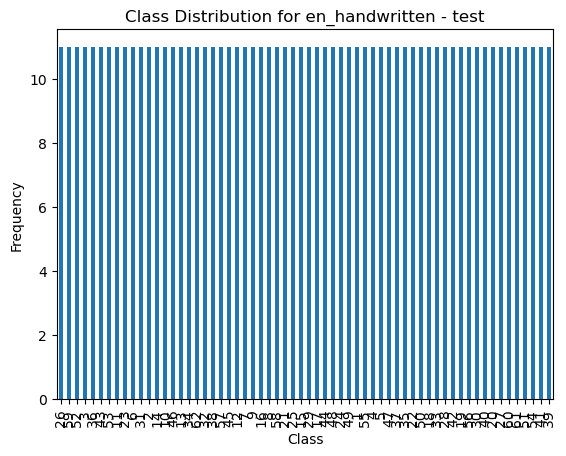

Dataset: en_handwritten, Data type: train
Number of samples: 2182
Class distribution: {1: 36, 31: 36, 13: 36, 60: 36, 26: 36, 49: 36, 17: 36, 6: 36, 10: 36, 58: 36, 51: 36, 57: 36, 41: 35, 21: 35, 24: 35, 45: 35, 62: 35, 20: 35, 44: 35, 5: 35, 15: 35, 9: 35, 22: 35, 50: 35, 2: 35, 36: 35, 3: 35, 32: 35, 30: 35, 52: 35, 39: 35, 40: 35, 61: 35, 54: 35, 28: 35, 38: 35, 12: 35, 37: 35, 29: 35, 25: 35, 14: 35, 7: 35, 55: 35, 27: 35, 56: 35, 35: 35, 33: 35, 8: 35, 23: 35, 59: 35, 47: 35, 16: 35, 18: 35, 19: 35, 34: 35, 46: 35, 53: 35, 48: 35, 43: 35, 42: 35, 11: 35, 4: 35}


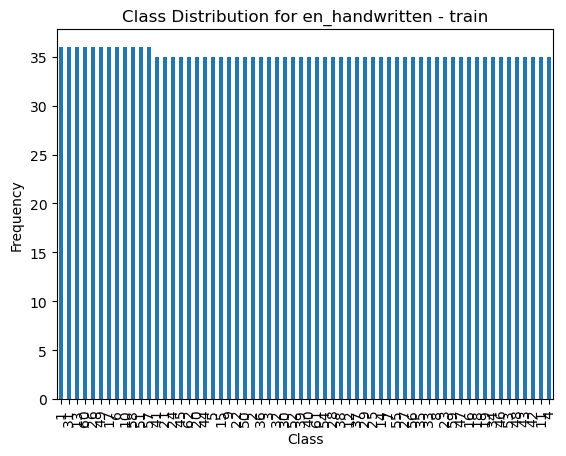

Dataset: en_handwritten, Data type: dev
Number of samples: 546
Class distribution: {2: 9, 62: 9, 27: 9, 18: 9, 61: 9, 9: 9, 19: 9, 14: 9, 32: 9, 38: 9, 54: 9, 50: 9, 47: 9, 21: 9, 29: 9, 39: 9, 23: 9, 33: 9, 42: 9, 55: 9, 48: 9, 45: 9, 40: 9, 11: 9, 22: 9, 3: 9, 30: 9, 46: 9, 28: 9, 16: 9, 53: 9, 7: 9, 20: 9, 37: 9, 15: 9, 35: 9, 41: 9, 44: 9, 4: 9, 12: 9, 24: 9, 5: 9, 56: 9, 34: 9, 52: 9, 43: 9, 8: 9, 59: 9, 25: 9, 36: 9, 49: 8, 13: 8, 26: 8, 31: 8, 60: 8, 58: 8, 6: 8, 51: 8, 17: 8, 1: 8, 57: 8, 10: 8}


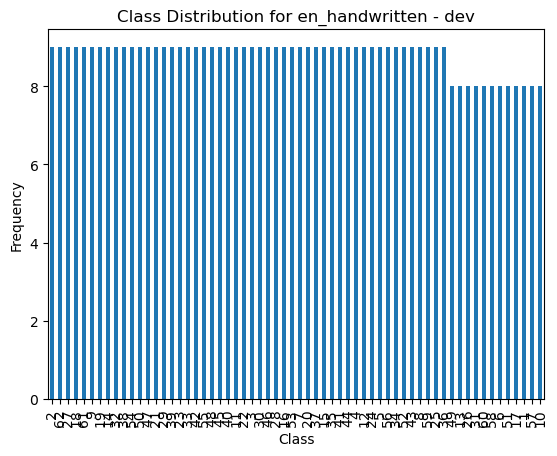

Dataset: hhd, Data type: test
Number of samples: 1134
Class distribution: {23: 46, 0: 45, 1: 45, 8: 45, 7: 45, 6: 45, 5: 45, 4: 45, 3: 45, 25: 45, 24: 45, 21: 45, 9: 45, 2: 45, 17: 45, 15: 45, 13: 45, 12: 45, 10: 45, 19: 44, 26: 44, 16: 33, 20: 33, 22: 32, 14: 31, 11: 31, 18: 30}


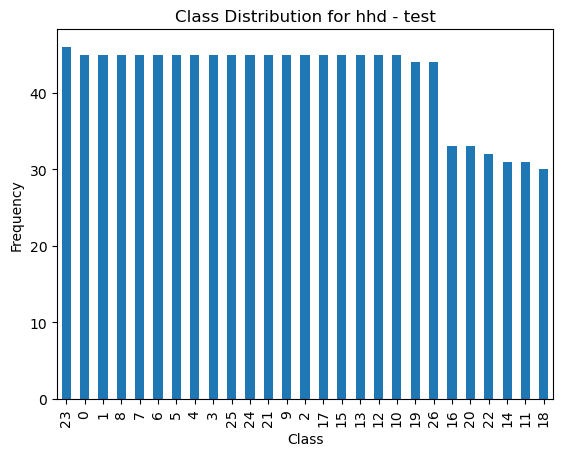

Dataset: hhd, Data type: train
Number of samples: 3172
Class distribution: {24: 137, 12: 120, 3: 119, 4: 119, 0: 119, 15: 119, 7: 119, 5: 119, 19: 119, 8: 119, 2: 119, 6: 119, 1: 119, 9: 119, 13: 119, 10: 119, 18: 119, 17: 118, 23: 118, 21: 116, 25: 116, 26: 115, 16: 107, 14: 107, 20: 107, 22: 105, 11: 100, 27: 21}


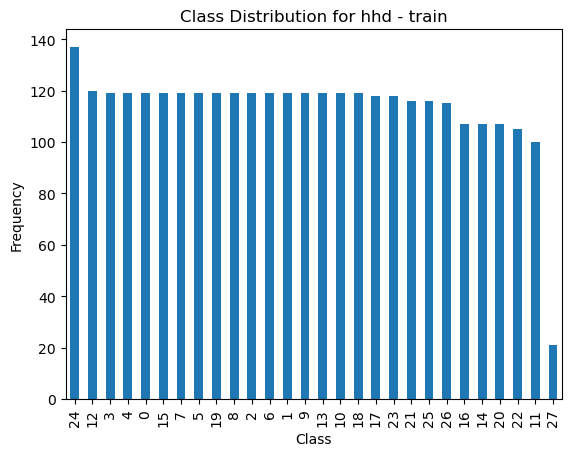

Dataset: hhd, Data type: dev
Number of samples: 793
Class distribution: {24: 34, 5: 30, 9: 30, 0: 30, 12: 30, 6: 30, 8: 30, 13: 30, 18: 30, 23: 30, 15: 30, 2: 30, 1: 30, 3: 30, 10: 30, 19: 30, 7: 30, 21: 29, 25: 29, 17: 29, 4: 29, 26: 28, 20: 27, 16: 26, 14: 26, 22: 26, 11: 25, 27: 5}


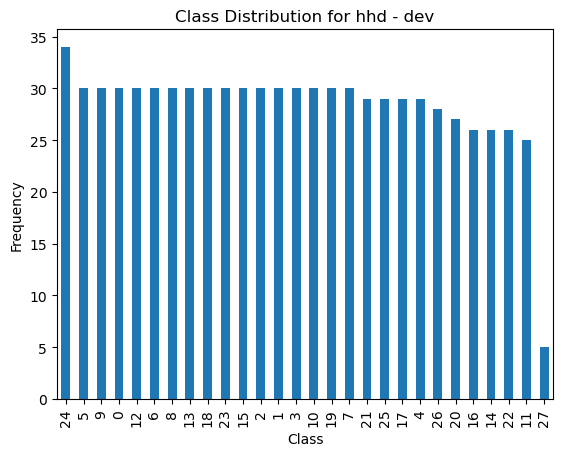

Dataset: mashtots, Data type: test
Number of samples: 14012
Class distribution: {39: 188, 31: 187, 48: 187, 54: 186, 61: 186, 15: 186, 50: 186, 49: 186, 37: 186, 58: 186, 19: 186, 42: 186, 41: 186, 26: 186, 72: 185, 2: 185, 70: 185, 45: 185, 29: 185, 46: 185, 13: 185, 40: 185, 22: 185, 76: 185, 68: 185, 47: 184, 71: 184, 51: 184, 59: 184, 65: 184, 28: 184, 32: 183, 18: 183, 52: 183, 73: 183, 43: 183, 34: 183, 57: 182, 44: 182, 53: 182, 8: 182, 62: 182, 63: 182, 11: 181, 56: 181, 12: 180, 21: 180, 77: 179, 4: 179, 35: 178, 69: 178, 55: 177, 10: 177, 9: 177, 36: 177, 17: 176, 66: 176, 60: 176, 16: 176, 67: 176, 33: 176, 24: 175, 30: 174, 64: 174, 1: 174, 74: 173, 38: 173, 7: 173, 25: 173, 0: 171, 75: 170, 27: 170, 20: 168, 3: 166, 23: 166, 6: 163, 14: 157, 5: 155}


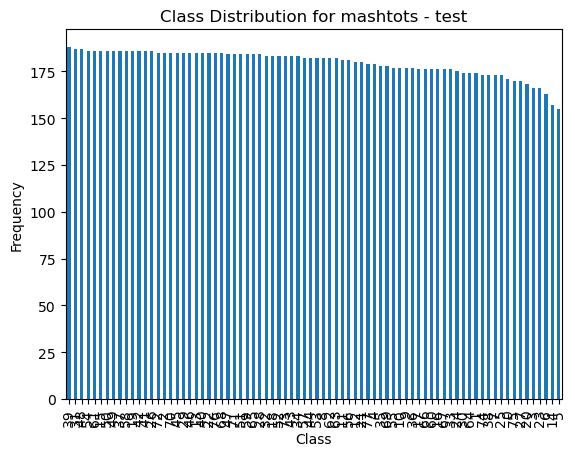

Dataset: mashtots, Data type: train
Number of samples: 44838
Class distribution: {39: 602, 48: 598, 19: 597, 50: 597, 61: 597, 31: 597, 37: 596, 15: 596, 26: 595, 49: 594, 58: 594, 41: 594, 54: 594, 22: 594, 13: 594, 42: 594, 29: 593, 76: 593, 70: 592, 46: 592, 45: 592, 68: 591, 40: 591, 72: 591, 2: 591, 59: 590, 47: 590, 65: 589, 51: 589, 71: 588, 18: 587, 43: 587, 28: 587, 73: 586, 34: 586, 52: 586, 32: 584, 62: 583, 8: 582, 53: 582, 44: 582, 57: 582, 63: 581, 56: 581, 11: 578, 12: 576, 21: 575, 4: 574, 77: 572, 69: 570, 35: 570, 55: 568, 36: 567, 10: 567, 9: 566, 66: 564, 33: 563, 16: 563, 67: 563, 17: 562, 60: 562, 24: 558, 1: 557, 64: 556, 30: 555, 25: 554, 38: 554, 74: 553, 7: 553, 27: 546, 0: 546, 75: 545, 20: 537, 3: 532, 23: 530, 6: 522, 14: 502, 5: 497}


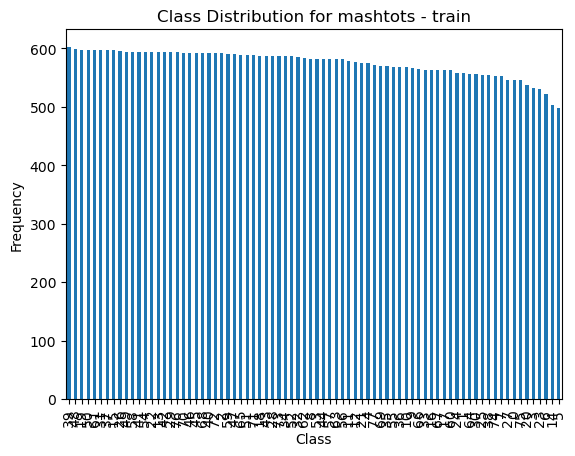

Dataset: mashtots, Data type: dev
Number of samples: 11210
Class distribution: {39: 150, 48: 150, 26: 149, 61: 149, 31: 149, 37: 149, 19: 149, 15: 149, 42: 149, 41: 149, 50: 149, 70: 148, 72: 148, 58: 148, 68: 148, 2: 148, 13: 148, 54: 148, 40: 148, 29: 148, 47: 148, 49: 148, 22: 148, 76: 148, 45: 148, 46: 148, 73: 147, 43: 147, 34: 147, 18: 147, 71: 147, 65: 147, 51: 147, 59: 147, 28: 147, 62: 146, 52: 146, 53: 146, 32: 146, 44: 145, 63: 145, 11: 145, 56: 145, 57: 145, 8: 145, 12: 144, 21: 144, 35: 143, 4: 143, 77: 143, 69: 143, 10: 142, 9: 142, 55: 142, 36: 142, 33: 141, 60: 141, 16: 141, 66: 141, 17: 141, 67: 141, 24: 140, 64: 139, 1: 139, 30: 139, 7: 138, 38: 138, 74: 138, 25: 138, 0: 137, 27: 136, 75: 136, 20: 134, 3: 133, 23: 133, 6: 130, 14: 126, 5: 124}


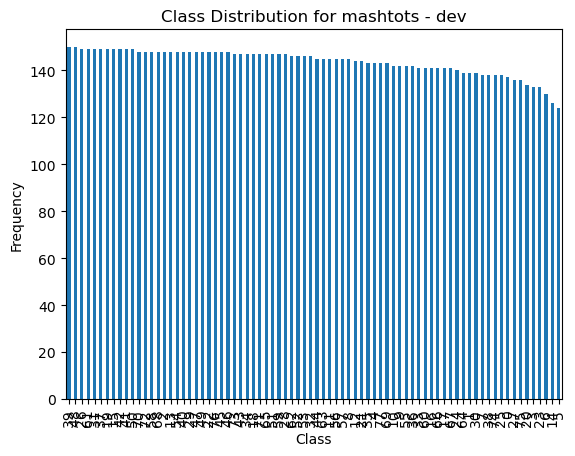

Dataset: emnist, Data type: test
Number of samples: 116323
Class distribution: {1: 6330, 7: 6139, 3: 5969, 2: 5869, 0: 5778, 6: 5705, 9: 5686, 8: 5633, 4: 5619, 5: 5190, 24: 4156, 40: 4092, 28: 3508, 55: 2965, 47: 2535, 53: 2320, 18: 2048, 30: 2002, 49: 1898, 12: 1739, 39: 1683, 36: 1644, 29: 1576, 22: 1485, 43: 1479, 15: 1440, 25: 1397, 23: 1351, 10: 1062, 37: 853, 14: 851, 21: 810, 27: 809, 32: 806, 34: 798, 31: 796, 13: 779, 11: 648, 19: 626, 42: 589, 17: 521, 52: 505, 56: 482, 59: 470, 57: 468, 58: 467, 50: 466, 46: 466, 35: 464, 48: 464, 61: 451, 16: 447, 54: 437, 33: 432, 38: 432, 44: 427, 26: 413, 41: 400, 20: 382, 60: 381, 51: 368, 45: 317}


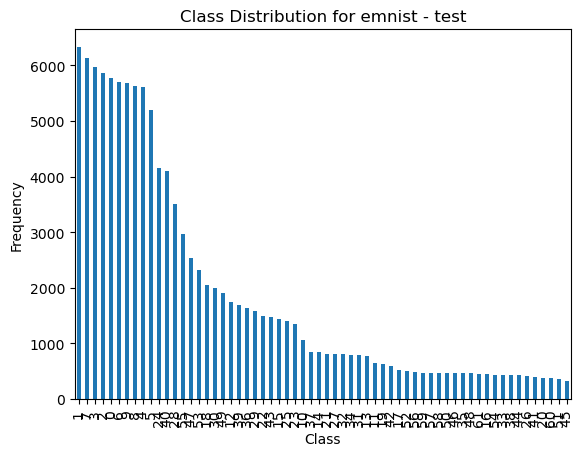

Dataset: emnist, Data type: train
Number of samples: 558345
Class distribution: {1: 30699, 7: 28603, 3: 28114, 0: 27668, 6: 27385, 2: 27362, 8: 27157, 9: 27077, 4: 26828, 5: 25133, 24: 19986, 40: 19705, 28: 16611, 55: 14609, 47: 12254, 53: 11284, 30: 10082, 18: 9557, 49: 9134, 39: 8142, 12: 8075, 36: 8026, 29: 7856, 15: 7346, 22: 7202, 43: 6990, 25: 6678, 23: 6590, 10: 5126, 37: 4127, 21: 4061, 27: 4058, 14: 3947, 34: 3794, 32: 3756, 31: 3710, 13: 3650, 11: 3102, 19: 3010, 42: 2950, 17: 2522, 52: 2395, 57: 2328, 38: 2283, 56: 2264, 59: 2258, 33: 2217, 50: 2199, 61: 2180, 44: 2180, 35: 2161, 54: 2159, 58: 2158, 48: 2116, 26: 2084, 41: 2049, 16: 2014, 46: 1993, 20: 1974, 51: 1958, 60: 1892, 45: 1517}


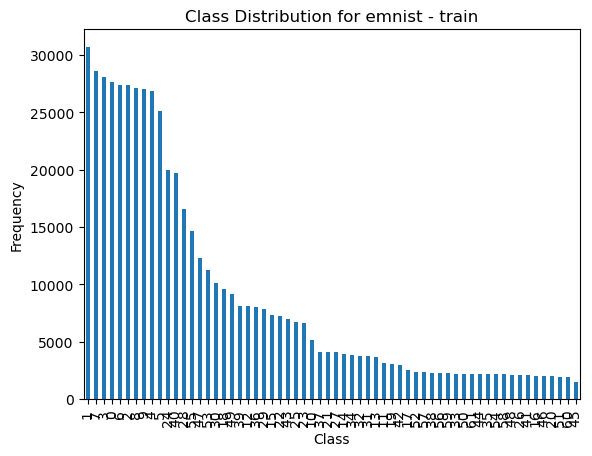

Dataset: emnist, Data type: dev
Number of samples: 139587
Class distribution: {1: 7675, 7: 7151, 3: 7029, 0: 6917, 6: 6847, 2: 6841, 8: 6789, 9: 6770, 4: 6707, 5: 6283, 24: 4997, 40: 4926, 28: 4153, 55: 3653, 47: 3064, 53: 2821, 30: 2520, 18: 2389, 49: 2284, 39: 2035, 12: 2019, 36: 2007, 29: 1964, 15: 1836, 22: 1800, 43: 1748, 25: 1669, 23: 1647, 10: 1281, 37: 1032, 27: 1015, 21: 1015, 14: 987, 34: 949, 32: 939, 31: 927, 13: 912, 11: 776, 19: 752, 42: 737, 17: 630, 52: 599, 57: 582, 38: 571, 56: 566, 59: 564, 33: 554, 50: 550, 61: 545, 44: 545, 35: 540, 54: 540, 58: 539, 48: 529, 26: 521, 41: 512, 16: 503, 46: 498, 20: 494, 51: 490, 60: 473, 45: 379}


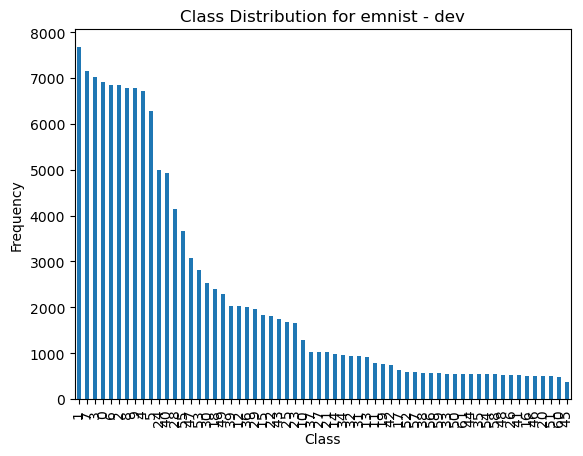

In [ ]:
import matplotlib.pyplot as plt

for dataset in datasets:
    for data_type in ['test', 'train', 'dev']:
        df = torch.load(preprocesssed_dir / f"{dataset}/{data_type}_df.pt", weights_only=False)
        
        # Print dataset info
        print(f"Dataset: {dataset}, Data type: {data_type}")
        print(f"Number of samples: {len(df)}")
        
        # Show class distribution
        class_counts = df['y'].value_counts()
        print("Class distribution:", class_counts.to_dict())
        
        # Plot class distribution
        plt.figure()
        class_counts.plot(kind='bar')
        plt.title(f"Class Distribution for {dataset} - {data_type}")
        plt.xlabel("Class")
        plt.ylabel("Frequency")
        plt.show()